# Analysis / Plotting - Notebook 08 - Growth Rate and Catastrophe Events
Author: Bettina Vignolo

This notebook was created to perform several smaller experiments with the microtubule model and analyze the results. It focuses on the calculation of growth rate / growth velocity and catastrophe events.


In [1]:
# load Packages:
using Agents
using Statistics
using DataFrames
using Distributions
using StatsBase
using DrWatson: @dict
using Serialization
using InteractiveDynamics
using GLMakie
import ColorSchemes as co
using DataFramesMeta

# load Functions:
include("01_Agent.jl")
include("02_Initialization.jl")
include("03_AgentStep.jl")
include("04_ModelStep.jl")
include("05_Analysis.jl")
ENV["COLUMNS"] = 250

250

In [46]:
#for parallelization
using Distributed
addprocs(8)

@everywhere begin
    # load Packages:
    using Agents
    using Statistics
    using DataFrames
    using Distributions
    using StatsBase
    using DrWatson: @dict
    using Serialization
    using InteractiveDynamics
    using GLMakie
    import ColorSchemes as co
    using DataFramesMeta

    # load Functions:
    include("01_Agent.jl")
    include("02_Initialization.jl")
    include("03_AgentStep.jl")
    include("04_ModelStep.jl")
    include("05_Analysis.jl")
end    

## 1. Functions

### 1.1 Growth Rate Function (by Valentin)

In [2]:
function growth_rate!(df) 
    df.growthrate = zeros(nrow(df))
    for n in 2:nrow(df)
        if df.step[n] == 0
            df.growthrate[n]=0
        elseif df.step[n]>0
            df.growthrate[n]= df[n,:mean_MT_size]-df[n-1,:mean_MT_size]
        end
    end
    return df
end

growth_rate! (generic function with 1 method)

### 1.2 Classification Function (incl. growth_rate function)

In [3]:
#count number of +1, -1 and 0 in each 250 step section and determine if this section is overall shrinking or growing

function growth_classification!(df; section_size = 250)
    df.growthrate = zeros(nrow(df))
    for n in 2:nrow(df)
        if df.step[n] == 0
            df.growthrate[n]=0
        elseif df.step[n]>0
            df.growthrate[n]= df[n,:mean_MT_size]-df[n-1,:mean_MT_size]
        end
    end

    df.growthclass = [0 for i in 1:nrow(df)]
    for i in collect(1:section_size:maximum(df.step)-section_size+1)
        section = collect(i:i+section_size-1)
        count_plus = count(x -> (x == 1.0), df.growthrate[section])
        count_minus = count(x -> (x == -1.0), df.growthrate[section])
        growthclass = count_minus >= 0.08*section_size ? -1.0 : count_plus >= 0.012*section_size ? 1.0 : 0.0

        for n in section
            df.growthclass[n] = growthclass
        end
    end

    df.growthclass_group = [1 for i in 1:nrow(df)]
    for (i,v) in enumerate(df.growthclass)
        if i == 1
            continue
        elseif v == df.growthclass[i-1]
            df.growthclass_group[i] = df.growthclass_group[i-1]
        else
            df.growthclass_group[i] = df.growthclass_group[i-1] + 1
        end
    end
    return df
end

growth_classification! (generic function with 1 method)

### 1.3 Velocity Function

In [4]:
function velocity(df)
    df_new = DataFrame(growthclass_group = [i for i in 1:maximum(df.growthclass_group)], velocity = zeros(maximum(df.growthclass_group)))

    for i in 1:maximum(df.growthclass_group) #find minimum/maximum of MT lenght and corresponding step for each group
        sub_df = @subset(df, :growthclass_group .== i)
        MT_min = minimum(sub_df.mean_MT_size)
        MT_max = maximum(sub_df.mean_MT_size)
        for (i,v) in enumerate(sub_df.mean_MT_size)
            if v == MT_min
                step_min = sub_df.step[i]
            end
            if v == MT_max
                step_max = sub_df.step[i]
            end
        end
        #calculate velocities for each group (should be negative if group is shrinking)
        if sub_df.growthclass[1] == 1.0
            df_new.velocity[i] = (MT_max-MT_min)/(step_max - step_min)
        elseif sub_df.growthclass[1] == -1.0
            df_new.velocity[i] = (MT_min-MT_max)/(step_max - step_min)
        else
            df_new.velocity[i] = 0
        end   
    end
    return df_new
end

function mean_velocity_grow(df)
    grow_velocities = [df.velocity[i] for i in 1:nrow(df) if df.velocity[i] > 0]
    if isempty(grow_velocities)
        mean_velocity_grow = 0
    else
        mean_velocity_grow = mean(grow_velocities)
    end
end

function mean_velocity_cat(df)
    cat_velocities = [df.velocity[i] for i in 1:nrow(df) if df.velocity[i] < 0]
    if isempty(cat_velocities)
        mean_velocity_cat = 0
    else
        mean_velocity_cat = mean(cat_velocities)
    end
end

mean_velocity_cat (generic function with 1 method)

## 2. Test Analysis

### 2.1 Test with only 1 Nstart and 2 different Parameters

In [6]:
#@everywhere begin
    parameters=Dict(
                :griddims => (100,100),
                :periodic => true,
                :Nstarts => 1,
                :numagents => 1000, 
                :p_hyd => 0.024,                   
                :p_polym=> 1.0 ,    
                :p_depolym_GTP => 0.0,
                :p_depolym_GDP => [0.2, 0.5],
                :p_GTP_exchange => 0.01)
    # Model Data:
    mdata = [mean_MT_size]
#end
# Run Model 
_ , paramdata = paramscan(parameters, initialize;  mdata, agent_step!, model_step!, n=100000, parallel = true)
serialize("data/growthrate_test_data_p_depolym_GDP_1Nstart_100ksteps.jls", paramdata)

In [7]:
data_test = deserialize("data/growthrate_test_data_p_depolym_GDP_1Nstart_100ksteps.jls");
data_02 = @subset(data_test, :p_depolym_GDP .== 0.2)
growth_classification!(data_02)

,step,mean_MT_size,p_depolym_GDP,growthrate,growthclass,growthclass_group
,Int64,Float64,Float64,Float64,Int64,Int64
1,0,1.0,0.2,0.0,1,1
2,1,1.0,0.2,0.0,1,1
3,2,1.0,0.2,0.0,1,1
4,3,1.0,0.2,0.0,1,1
5,4,1.0,0.2,0.0,1,1
6,5,1.0,0.2,0.0,1,1
7,6,1.0,0.2,0.0,1,1
8,7,1.0,0.2,0.0,1,1
9,8,1.0,0.2,0.0,1,1


In [8]:
data_05 = @subset(data_test, :p_depolym_GDP .== 0.5)
growth_classification!(data_05)

,step,mean_MT_size,p_depolym_GDP,growthrate,growthclass,growthclass_group
,Int64,Float64,Float64,Float64,Int64,Int64
1,0,1.0,0.5,0.0,1,1
2,1,1.0,0.5,0.0,1,1
3,2,1.0,0.5,0.0,1,1
4,3,1.0,0.5,0.0,1,1
5,4,1.0,0.5,0.0,1,1
6,5,1.0,0.5,0.0,1,1
7,6,1.0,0.5,0.0,1,1
8,7,1.0,0.5,0.0,1,1
9,8,1.0,0.5,0.0,1,1


In [9]:
maximum(data_05.growthclass_group)

198

In [10]:
data_05_velocity = velocity!(data_05)

LoadError: UndefVarError: velocity! not defined

In [11]:
mean_velocity_grow(data_05_velocity)


LoadError: UndefVarError: data_05_velocity not defined

In [62]:
mean_velocity_cat(data_05_velocity)

-0.050575381836289394

In [12]:
data_02_velocity = velocity!(data_02)

println(mean_velocity_grow(data_02_velocity))
println(mean_velocity_cat(data_02_velocity))

LoadError: UndefVarError: velocity! not defined

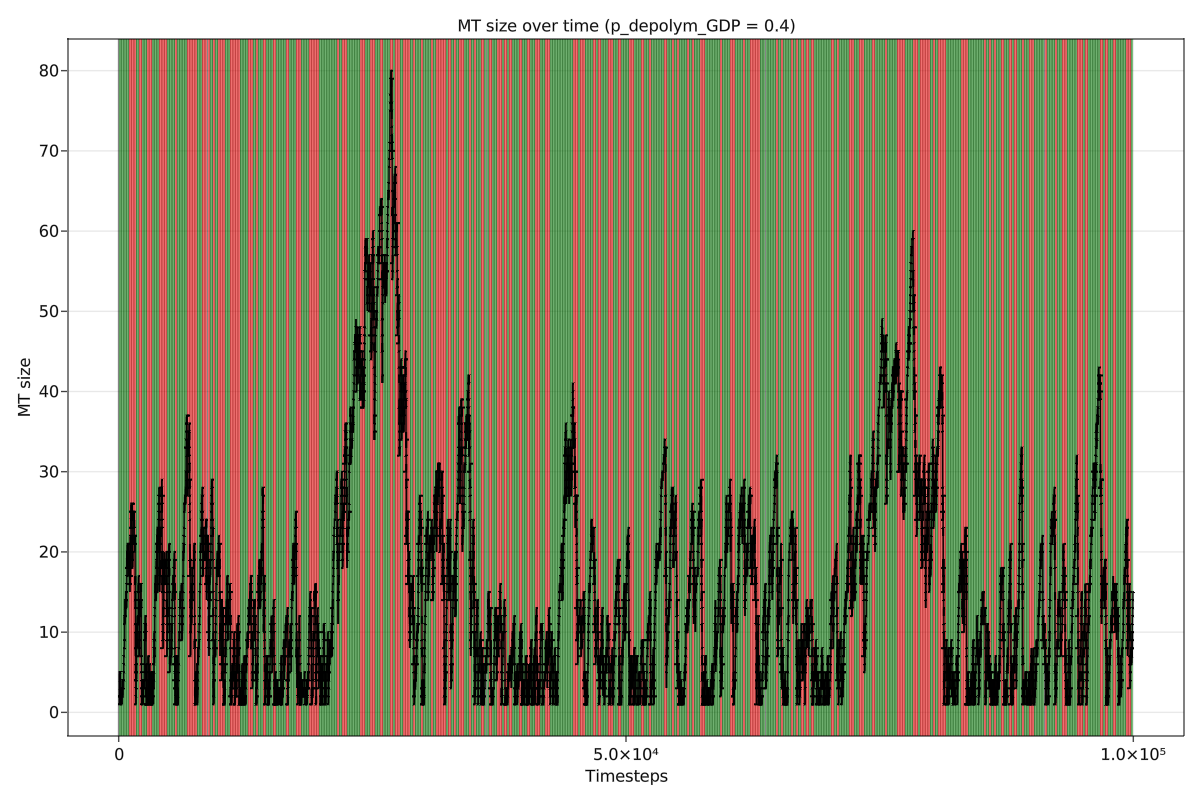

In [13]:
#plot growthclass + MT length
f1_1 = Figure(resolution =(1200, 800))
ax1_1 = Axis(f1_1[1,1:2]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time (p_depolym_GDP = 0.4)", yticks=LinearTicks(10))

for i in collect(1:250:99751)
    vlines!(ax1_1, i, color = (:black, 0.5))
end

for i in collect(1:250:99751)
    if data_05.growthclass[i] == -1.0
        vspan!(ax1_1, i, i+249, color = (:red, 0.5), label = "catastrophe")
    elseif data_05.growthclass[i] == 1.0
        vspan!(ax1_1, i, i+249, color = (:green, 0.5), label = "growth")
    end
end
lines!(ax1_1, data_05.step, data_05.mean_MT_size, label = "MT length", color = :black)
f1_1

### 2.2 Test 2: Compare Growth Velocity of ensembled models for different parameters

In [ ]:
models = [initialize(;
        Nstarts = 1,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.02,
        p_GTP_exchange = 0.01,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = x)  
    for x in repeat(collect([0:0.1:1]...), 10)]
mdata = [mean_MT_size, (:p_depolym_GDP)]
mlabels = ["mean MT length", "p_depolym_GDP"]

data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata)
serialize("data/growthrate_test_data_p_depolym_GDP_10ensemble_1Nstart_10ksteps.jls", data_ens[2])

In [85]:
data2_2 = deserialize("data/growthrate_test_data_p_depolym_GDP_10ensemble_1Nstart_10ksteps.jls")
mean_velocity_per_ensemble = []
ensemble_p_depolym = repeat(collect(0.0:0.1:1.0), 10)

for i in 1:110
    sub_df = @subset(data2_2, :ensemble .== i)
    sub_df_grow = growth_classification!(sub_df)
    sub_df_velocity = velocity!(sub_df_grow)    
    push!(mean_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
end

summary = DataFrame(p_depolym_GDP = ensemble_p_depolym, mean_velocity = mean_velocity_per_ensemble)
gdf = groupby(summary, :p_depolym_GDP)
final = combine(gdf, [:mean_velocity] .=> [mean])


,p_depolym_GDP,mean_velocity_mean
,Float64,Float64
1,0.0,0.0432759
2,0.1,0.031532
3,0.2,0.0280415
4,0.3,0.0279959
5,0.4,0.0310627
6,0.5,0.0304314
7,0.6,0.0279088
8,0.7,0.0294697
9,0.8,0.0286975


In [88]:
fig = Figure()
ax = Axis(fig[1,1], xticks = LinearTicks(11), ylabel = "Mean Growing Velocity", xlabel = "p_depolym_GDP")
lines!(ax, final.p_depolym_GDP, final.mean_velocity_mean)
fig

### 2.3 Repeat Test 2 with more ensembles (p_depolym_GDP)
runtime 234min

In [2]:
@everywhere begin
    models = [initialize(;
            Nstarts = 1,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = 0.02,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = x)  
        for x in repeat(collect([0:0.1:1]...), 40)]
    mdata = [mean_MT_size, (:p_depolym_GDP)]
    mlabels = ["mean MT length", "p_depolym_GDP"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_p_depolym_GDP_40ensemble_1Nstart_10ksteps.jls", data_ens[2])

In [10]:
data2_3 = deserialize("data/growthrate_test_data_p_depolym_GDP_40ensemble_1Nstart_10ksteps.jls")
mean_gr_velocity_per_ensemble = []
gr_frequency = []
mean_cat_velocity_per_ensemble = []
cat_frequency = []
ensemble_p_depolym = repeat(collect(0.0:0.1:1.0), 40)

for i in 1:440 #number of ensembles
    sub_df_velocity = velocity(growth_classification!(@subset(data2_3, :ensemble .== i), section_size = 200))    
    push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
    push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))

    push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
    push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)
end

summary = DataFrame(p_depolym_GDP = ensemble_p_depolym, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency )
gdf = groupby(summary, :p_depolym_GDP)
final = combine(gdf, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,p_depolym_GDP,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0437005,0.0,0.000125,0.0
2,0.1,0.0305958,-0.0089196,0.000125,2.25e-5
3,0.2,0.0298643,-0.0432007,0.0004625,0.000355
4,0.3,0.0315309,-0.0488533,0.000855,0.000765
5,0.4,0.0330733,-0.0578501,0.0009625,0.000885
6,0.5,0.0319987,-0.0631921,0.00113,0.001065
7,0.6,0.031835,-0.0700232,0.001155,0.0010875
8,0.7,0.0301323,-0.0743622,0.00112,0.00104
9,0.8,0.0291933,-0.0770698,0.0010875,0.0009875


In [16]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), xlabel = "p_depolym_GDP")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(13), yticks = LinearTicks(7), xlabel = "p_depolym_GDP")
ylims!(ax2, 0, 0.0014)
ylims!(ax2_2, 0, 0.0014)
barplot!(ax2_2, final.p_depolym_GDP, final.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_2, final.p_depolym_GDP, final.grow_frequency_mean, final.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final.p_depolym_GDP, final.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2, final.p_depolym_GDP, final.cat_frequency_mean, final.cat_frequency_std, color = :black, whiskerwidth = 10)

axislegend(ax2)
axislegend(ax2_2)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [15]:
#Growth and Catastrophe velocities plotted
fig2_1 = Figure(resolution = (600,600))
ax2_1 = Axis(fig2_1[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "p_depolym_GDP")

barplot!(ax2_1, final.p_depolym_GDP, final.velocity_grow_mean, gap = 0, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_1, final.p_depolym_GDP, final.velocity_grow_mean, [0 for i in 1:nrow(final)], final.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_1, final.p_depolym_GDP, final.velocity_cat_mean, gap = 0, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_1, final.p_depolym_GDP, final.velocity_cat_mean, final.velocity_cat_std, [0 for i in 1:nrow(final)], color = :black, whiskerwidth = 10)

hlines!(ax2_1, 0, color = :black)
axislegend(ax2_1)
fig2_1

In [3]:
gdf = groupby(data2_3, [:step, :p_depolym_GDP]) #:ensemble .!= 88, :ensemble .!= 86         
sum_2_3 = combine(gdf, [:mean_MT_size] .=> [mean]);

In [4]:
#MT length over time
f2_3 = Figure(resolution =(1200, 600))
ax2_3 = Axis(f2_3[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time (40x ensemble)")
range = collect(0.0:0.1:1.0)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_3, :p_depolym_GDP .== v)
    lines!(ax2_3, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_3[2,1], ax2_3, "p_depolym_GDP", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_3)

GLMakie.Screen(...)

In [40]:
#MT length over time for single ensemble
f2_3_1 = Figure(resolution =(1200, 600))
ax2_3_1 = Axis(f2_3_1[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time (10x ensemble) - excluded ensemble..")
range = [0.5]#collect(0.0:0.1:1.0)

for (i,v) in enumerate(range)
    sub_data = @subset(data2_3, :p_depolym_GDP .== v, :ensemble .== 6)
    lines!(ax2_3_1, sub_data.step, sub_data.mean_MT_size, label = "$v", color = co.tab20[i])
end


Legend(f2_3_1[2,1], ax2_3_1, "p_depolym_GDP", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_3_1)

GLMakie.Screen(...)

### 2.4 Ensemble for p_polym
runtime 239 min

In [2]:
@everywhere begin
    models = [initialize(;
            Nstarts = 1,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = x,
            p_hyd = 0.024,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.1)  
        for x in repeat(collect([0:0.1:1]...), 40)]
    mdata = [mean_MT_size, (:p_depolym_GDP)]
    mlabels = ["mean MT length", "p_depolym_GDP"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_p_polym_40ensemble_1Nstart_10ksteps.jls", data_ens[2])

In [4]:
data2_4_1 = deserialize("data/growthrate_test_data_p_polym_40ensemble_1Nstart_10ksteps.jls")
ensemble_p_polym = repeat(collect(0.0:0.1:1.0), 40)
ensembles = collect(1:440)
df = DataFrame(ensemble = ensembles, p_polym = ensemble_p_polym)
data2_4 = innerjoin(data2_4_1, df, on = :ensemble)

,step,mean_MT_size,p_depolym_GDP,ensemble,p_polym
,Int64,Float64,Float64,Int64,Float64
1,0,1.0,0.1,1,0.0
2,1,1.0,0.1,1,0.0
3,2,1.0,0.1,1,0.0
4,3,1.0,0.1,1,0.0
5,4,1.0,0.1,1,0.0
6,5,1.0,0.1,1,0.0
7,6,1.0,0.1,1,0.0
8,7,1.0,0.1,1,0.0
9,8,1.0,0.1,1,0.0


In [11]:
mean_gr_velocity_per_ensemble = []
mean_cat_velocity_per_ensemble = []
gr_frequency = []
cat_frequency = []
ensemble_p_polym = repeat(collect(0.1:0.1:1.0), 40)
data2_4_2 = @subset(data2_4, :p_polym .!= 0.0)
for i in 1:440 #number of ensembles
    if i ∉ [(1+n*11) for n in 0:39]
    sub_df_velocity = velocity!(growth_classification!(@subset(data2_4, :ensemble .== i)))    
    push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
    push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))
    
    push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
    push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)

    end
end

summary = DataFrame(p_polym = ensemble_p_polym, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency )
gdf = groupby(summary, :p_polym)
final = combine(gdf, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,p_polym,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Float64,Float64,Float64,Float64,Float64
1,0.1,0.00776544,0.0,0.0010225,0.0
2,0.2,0.00573337,0.0,0.0005825,0.0
3,0.3,0.00487024,-0.0111446,0.000265,2.25e-5
4,0.4,0.0060028,-0.0278088,0.0001975,7.25e-5
5,0.5,0.0105231,-0.0388052,0.0002075,0.00011
6,0.6,0.0131673,-0.0204317,0.000165,6.0e-5
7,0.7,0.0178795,-0.0174029,0.00015,5.0e-5
8,0.8,0.0227403,-0.0107418,0.00014,4.0e-5
9,0.9,0.0241031,-0.00853414,0.0001225,2.25e-5


In [36]:
#Growth and Catastrophe velocities plotted
fig2_4 = Figure(resolution = (600,600))
ax2_4 = Axis(fig2_4[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "p_polym")

barplot!(ax2_4, final.p_polym, final.velocity_grow_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_4, final.p_polym, final.velocity_grow_mean, [0 for i in 1:nrow(final)], final.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_4, final.p_polym, final.velocity_cat_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_4, final.p_polym, final.velocity_cat_mean, final.velocity_cat_std, [0 for i in 1:nrow(final)], color = :black, whiskerwidth = 10)

hlines!(ax2_4, 0, color = :black)
axislegend(ax2_4, position = :lt)
fig2_4

In [72]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), xlabel = "p_polym")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(13), yticks = LinearTicks(7), xlabel = "p_polym")
ylims!(ax2, 0, 0.0013)
ylims!(ax2_2, 0, 0.0013)
barplot!(ax2_2, final.p_polym, final.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_2, final.p_polym, final.grow_frequency_mean, final.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final.p_polym, final.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2, final.p_polym, final.cat_frequency_mean, final.cat_frequency_std, color = :black, whiskerwidth = 10)

axislegend(ax2)
axislegend(ax2_2)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [30]:
gdf = groupby(data2_4, [:step, :p_polym]) #:ensemble .!= 88, :ensemble .!= 86         
sum_2_4 = combine(gdf, [:mean_MT_size] .=> [mean])

,step,p_polym,mean_MT_size_mean
,Int64,Float64,Float64
1,0,0.0,1.0
2,1,0.0,1.0
3,2,0.0,1.0
4,3,0.0,1.0
5,4,0.0,1.0
6,5,0.0,1.0
7,6,0.0,1.0
8,7,0.0,1.0
9,8,0.0,1.0


In [32]:
#MT length over time
f2_4 = Figure(resolution =(1200, 600))
ax2_4 = Axis(f2_4[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time (10x ensemble) - excluded ensemble..")
range = collect(0.0:0.1:0.1)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_4, :p_polym .== v)
    lines!(ax2_4, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_4[2,1], ax2_4, "p_polym", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_4)

GLMakie.Screen(...)

### 2.5 Ensemble for p_hyd
runtime 11 min

In [2]:
@everywhere begin
    models = [initialize(;
            Nstarts = 4,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = x,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat(collect([0.003:0.003:0.03]...), 10)]
    mdata = [mean_MT_size, MT_size_each, (:p_hyd)]
    mlabels = ["mean MT length", "MT_size_each", "p_hyd"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_p_hyd_10ensemble_4Nstart_10ksteps.jls", data_ens[2])

In [17]:
data2_5 = deserialize("data/growthrate_test_data_p_hyd_10ensemble_4Nstart_10ksteps.jls")

mean_gr_velocity_per_ensemble = []
gr_frequency = []
mean_cat_velocity_per_ensemble = []
cat_frequency = []
ensemble_p_hyd = repeat(collect(0.003:0.003:0.03), 40)

for i in 1:4 #number of Nstarts/MTs per ensemble
    data2_5.mean_MT_size = [x[i] for x in data2_5.MT_size_each]
    for e in 1:100 #number of total ensembles        
        sub_df_velocity = velocity(growth_classification!(@subset(data2_5, :ensemble .== e), section_size = 200))
            
        push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
        push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))

        push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
        push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)
        
    end
end

summary2_5 = DataFrame(p_hyd = ensemble_p_hyd, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency)
gdf2_5 = groupby(summary2_5, :p_hyd)
final2_5 = combine(gdf2_5, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,p_hyd,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Float64,Float64,Float64,Float64,Float64
1,0.003,0.0304711,-0.00414573,0.000215,5.0e-6
2,0.006,0.0279269,-0.0240775,0.0002525,6.75e-5
3,0.009,0.0264913,-0.0603015,0.00031,0.000175
4,0.012,0.0276195,-0.0714016,0.000665,0.0005475
5,0.015,0.0290934,-0.0722715,0.0008975,0.000805
6,0.018,0.0308432,-0.0671354,0.00112,0.001045
7,0.021,0.0300291,-0.0603746,0.001155,0.001095
8,0.024,0.028982,-0.0539565,0.00123,0.00118
9,0.027,0.0290557,-0.0475653,0.0012875,0.0012225


In [19]:
#Growth and Catastrophe velocities plotted
fig2_5 = Figure(resolution = (750,600))
ax2_5 = Axis(fig2_5[1,1], xticks = LinearTicks(12), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "p_hyd")

barplot!(ax2_5, final2_5.p_hyd, final2_5.velocity_grow_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_5, final2_5.p_hyd, final2_5.velocity_grow_mean, [0 for i in 1:nrow(final2_5)], final2_5.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_5, final2_5.p_hyd, final2_5.velocity_cat_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_5, final2_5.p_hyd, final2_5.velocity_cat_mean, final2_5.velocity_cat_std, [0 for i in 1:nrow(final2_5)], color = :black, whiskerwidth = 10)

hlines!(ax2_5, 0, color = :black)
axislegend(ax2_5, position = :rb)
fig2_5

In [22]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_hyd")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_hyd")
ylims!(ax2, 0, 0.0015)
ylims!(ax2_2, 0, 0.0015)
barplot!(ax2_2, final2_5.p_hyd, final2_5.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_2, final2_5.p_hyd, final2_5.grow_frequency_mean, final2_5.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final2_5.p_hyd, final2_5.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2, final2_5.p_hyd, final2_5.cat_frequency_mean, final2_5.cat_frequency_std, color = :black, whiskerwidth = 10)

#hlines!(ax2, 0, color = :black)
axislegend(ax2, position = :lt)
axislegend(ax2_2, position = :lt)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [32]:
#MT length over time
data2_5 = deserialize("data/growthrate_test_data_p_hyd_10ensemble_4Nstart_10ksteps.jls")
gdf = groupby(data2_5, [:step, :p_hyd])   
sum_2_5 = combine(gdf, [:mean_MT_size] .=> [mean])

f2_5_2 = Figure(resolution =(1200, 600))
ax2_5_2 = Axis(f2_5_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "MT length over time (40x ensemble)")
range = collect(0.003:0.003:0.03)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_5, :p_hyd .== v)
    lines!(ax2_5_2, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_5_2[2,1], ax2_5_2, "p_hyd", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_5_2)

GLMakie.Screen(...)

### 2.6 Ensemble for p_GTP_exchange
runtime 12 min?

In [2]:
@everywhere begin
    models = [initialize(;
            Nstarts = 4,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = 0.024,
            p_GTP_exchange = x,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat([0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.4, 0.6, 1.0], 10)]
    mdata = [mean_MT_size, MT_size_each, (:p_GTP_exchange)]
    mlabels = ["mean MT length", "MT_size_each", "p_GTP_exchange"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_p_GTP_exchange_10ensemble_4Nstart_10ksteps.jls", data_ens[2])

In [23]:
data2_6 = deserialize("data/growthrate_test_data_p_GTP_exchange_10ensemble_4Nstart_10ksteps.jls")

mean_gr_velocity_per_ensemble = []
gr_frequency = []
mean_cat_velocity_per_ensemble = []
cat_frequency = []
ensemble_p_GTP_exchange = repeat([0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.4, 0.6, 1.0], 40)

for i in 1:4 #number of Nstarts/MTs per ensemble
    data2_6.mean_MT_size = [x[i] for x in data2_6.MT_size_each]
    for e in 1:110 #number of total ensembles        
        sub_df_velocity = velocity(growth_classification!(@subset(data2_6, :ensemble .== e), section_size = 200))
            
        push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
        push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))

        push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
        push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)
        
    end
end

summary2_6 = DataFrame(p_GTP_exchange = ensemble_p_GTP_exchange, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency)
gdf2_6 = groupby(summary2_6, :p_GTP_exchange)
final2_6 = combine(gdf2_6, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,p_GTP_exchange,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0132623,-0.0254109,0.00113,0.001035
2,0.01,0.0300312,-0.0505631,0.001285,0.001225
3,0.025,0.0314295,-0.060253,0.0012775,0.00122
4,0.05,0.0309928,-0.0571765,0.0012175,0.0011425
5,0.075,0.0302161,-0.0577994,0.0011,0.00104
6,0.1,0.0300922,-0.055339,0.001025,0.00095
7,0.15,0.0290939,-0.0560114,0.0009575,0.0008675
8,0.2,0.0263811,-0.0516643,0.000825,0.000735
9,0.4,0.0235211,-0.0500538,0.0004925,0.0004


In [24]:
#Growth and Catastrophe velocities plotted
fig2_6 = Figure(resolution = (600,600))
ax2_6 = Axis(fig2_6[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "p_GTP_exchange")

barplot!(ax2_6, final2_6.p_GTP_exchange, final2_6.velocity_grow_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_6, final2_6.p_GTP_exchange, final2_6.velocity_grow_mean, [0 for i in 1:nrow(final2_6)], final2_6.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_6, final2_6.p_GTP_exchange, final2_6.velocity_cat_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_6, final2_6.p_GTP_exchange, final2_6.velocity_cat_mean, final2_6.velocity_cat_std, [0 for i in 1:nrow(final2_6)], color = :black, whiskerwidth = 10)

hlines!(ax2_6, 0, color = :black)
axislegend(ax2_6, position = :rb)
fig2_6

In [36]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_GTP_exchange")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_GTP_exchange")
ylims!(ax2, 0, 0.00135)
ylims!(ax2_2, 0, 0.00135)
barplot!(ax2_2, final2_6.p_GTP_exchange, final2_6.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_2, final2_6.p_GTP_exchange, final2_6.grow_frequency_mean, final2_6.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final2_6.p_GTP_exchange, final2_6.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2, final2_6.p_GTP_exchange, final2_6.cat_frequency_mean, final2_6.cat_frequency_std, color = :black, whiskerwidth = 10)

#hlines!(ax2, 0, color = :black)
axislegend(ax2, position = :lt)
axislegend(ax2_2, position = :lt)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [37]:
#MT length over time
data2_6 = deserialize("data/growthrate_test_data_p_GTP_exchange_10ensemble_4Nstart_10ksteps.jls")

gdf = groupby(data2_6, [:step, :p_GTP_exchange])   
sum_2_6 = combine(gdf, [:mean_MT_size] .=> [mean])

f2_6_2 = Figure(resolution =(1200, 600))
ax2_6_2 = Axis(f2_6_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "MT length over time (40x ensemble)")
range = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.4, 0.6, 1.0]

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_6, :p_GTP_exchange .== v)
    lines!(ax2_6_2, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_6_2[2,1], ax2_6_2, "p_GTP_exchange", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_6_2)

GLMakie.Screen(...)

#### 2.6.2 Repeat with other parameter values

In [48]:
@everywhere begin
    models = [initialize(;
            Nstarts = 4,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = 0.024,
            p_GTP_exchange = x,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat(collect([0.0:0.05:0.5]...), 10)]
    mdata = [mean_MT_size, MT_size_each, (:p_GTP_exchange)]
    mlabels = ["mean MT length", "MT_size_each", "p_GTP_exchange"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_p_GTP_exchange_other_range_10ensemble_4Nstart_10ksteps.jls", data_ens[2])

In [25]:
data2_6_2 = deserialize("data/growthrate_test_data_p_GTP_exchange_other_range_10ensemble_4Nstart_10ksteps.jls")

mean_gr_velocity_per_ensemble = []
gr_frequency = []
mean_cat_velocity_per_ensemble = []
cat_frequency = []
ensemble_p_GTP_exchange = repeat(collect(0.0:0.05:0.5), 40)

for i in 1:4 #number of Nstarts/MTs per ensemble
    data2_6_2.mean_MT_size = [x[i] for x in data2_6_2.MT_size_each]
    for e in 1:110 #number of total ensembles        
        sub_df_velocity = velocity(growth_classification!(@subset(data2_6_2, :ensemble .== e), section_size = 200))
            
        push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
        push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))

        push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
        push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)
        
    end
end

summary2_6_2 = DataFrame(p_GTP_exchange = ensemble_p_GTP_exchange, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency)
gdf2_6_2 = groupby(summary2_6_2, :p_GTP_exchange)
final2_6_2 = combine(gdf2_6_2, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,p_GTP_exchange,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0129851,-0.0262891,0.0010325,0.00095
2,0.05,0.0306802,-0.0589072,0.001205,0.001125
3,0.1,0.0302874,-0.0599792,0.001125,0.00107
4,0.15,0.0287994,-0.0595411,0.001005,0.0009225
5,0.2,0.0275248,-0.0570654,0.00082,0.0007425
6,0.25,0.026575,-0.0542872,0.0008775,0.0007875
7,0.3,0.024305,-0.0557971,0.0006525,0.0005575
8,0.35,0.0242,-0.0532674,0.0005825,0.0004975
9,0.4,0.0243592,-0.0483476,0.0005075,0.0003975


In [26]:
#Growth and Catastrophe velocities plotted
fig2_6_2 = Figure(resolution = (600,600))
ax2_6_2 = Axis(fig2_6_2[1,1], xticks = LinearTicks(13), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "p_GTP_exchange")

barplot!(ax2_6_2, final2_6_2.p_GTP_exchange, final2_6_2.velocity_grow_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_6_2, final2_6_2.p_GTP_exchange, final2_6_2.velocity_grow_mean, [0 for i in 1:nrow(final2_6_2)], final2_6_2.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_6_2, final2_6_2.p_GTP_exchange, final2_6_2.velocity_cat_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_6_2, final2_6_2.p_GTP_exchange, final2_6_2.velocity_cat_mean, final2_6_2.velocity_cat_std, [0 for i in 1:nrow(final2_6_2)], color = :black, whiskerwidth = 10)

hlines!(ax2_6_2, 0, color = :black)
axislegend(ax2_6_2, position = :rb)
fig2_6_2

In [29]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_GTP_exchange")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(12), yticks = LinearTicks(7), xlabel = "p_GTP_exchange")
ylims!(ax2, 0, 0.0015)
ylims!(ax2_2, 0, 0.0015)
barplot!(ax2_2, final2_6_2.p_GTP_exchange, final2_6_2.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2_2, final2_6_2.p_GTP_exchange, final2_6_2.grow_frequency_mean, final2_6_2.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final2_6_2.p_GTP_exchange, final2_6_2.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2, gap = 0, width = 0.04)
errorbars!(ax2, final2_6_2.p_GTP_exchange, final2_6_2.cat_frequency_mean, final2_6_2.cat_frequency_std, color = :black, whiskerwidth = 10)


axislegend(ax2, position = :rt)
axislegend(ax2_2, position = :rt)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [56]:
#MT length over time
data2_6_2 = deserialize("data/growthrate_test_data_p_GTP_exchange_other_range_10ensemble_4Nstart_10ksteps.jls")

gdf = groupby(data2_6_2, [:step, :p_GTP_exchange])   
sum_2_6_2 = combine(gdf, [:mean_MT_size] .=> [mean])

f2_6_2_2 = Figure(resolution =(1200, 600))
ax2_6_2_2 = Axis(f2_6_2_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "MT length over time (40x ensemble)")
range = collect(0.0:0.05:0.5)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_6_2, :p_GTP_exchange .== v)
    lines!(ax2_6_2_2, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_6_2_2[2,1], ax2_6_2_2, "p_GTP_exchange", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_6_2_2)

GLMakie.Screen(...)

### 2.7 Ensemble for numagents
runtime 12 min?

In [3]:
@everywhere begin
    models = [initialize(;
            Nstarts = 4,
            periodic = true,
            numagents = x,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = 0.024,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat(collect(400:200:1800), 10)]
    mdata = [mean_MT_size, MT_size_each, (:numagents)]
    mlabels = ["mean MT length", "MT_size_each", "numagents"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true)
serialize("data/growthrate_test_data_numagents_10ensemble_4Nstart_10ksteps.jls", data_ens[2])

In [30]:
data2_7 = deserialize("data/growthrate_test_data_numagents_10ensemble_4Nstart_10ksteps.jls")

mean_gr_velocity_per_ensemble = []
gr_frequency = []
mean_cat_velocity_per_ensemble = []
cat_frequency = []
ensemble_numagents = repeat(collect(400:200:1800), 40)

for i in 1:4 #number of Nstarts/MTs per ensemble
    data2_7.mean_MT_size = [x[i] for x in data2_7.MT_size_each]
    for e in 1:80 #number of total ensembles        
        sub_df_velocity = velocity(growth_classification!(@subset(data2_7, :ensemble .== e), section_size = 200))
            
        push!(mean_gr_velocity_per_ensemble, mean_velocity_grow(sub_df_velocity))
        push!(mean_cat_velocity_per_ensemble, mean_velocity_cat(sub_df_velocity))

        push!(gr_frequency, count(i->(i > 0), sub_df_velocity.velocity)/10000)
        push!(cat_frequency, count(i->(i < 0), sub_df_velocity.velocity)/10000)
        
    end
end

summary2_7 = DataFrame(numagents = ensemble_numagents, velocity_grow = mean_gr_velocity_per_ensemble,
 velocity_cat = mean_cat_velocity_per_ensemble, grow_frequency = gr_frequency, cat_frequency = cat_frequency)
gdf2_7 = groupby(summary2_7, :numagents)
final2_7 = combine(gdf2_7, [:velocity_grow , :velocity_cat, :grow_frequency, :cat_frequency] .=> [mean std])


,numagents,velocity_grow_mean,velocity_cat_mean,grow_frequency_mean,cat_frequency_mean
,Int64,Float64,Float64,Float64,Float64
1,400,0.00591,-0.0197756,0.00076,9.25e-5
2,600,0.00985572,-0.0387967,0.0007025,0.000435
3,800,0.0193419,-0.0468317,0.0010375,0.0009575
4,1000,0.0297098,-0.050239,0.00125,0.00118
5,1200,0.0388824,-0.0585172,0.00121,0.001165
6,1400,0.0440689,-0.0590016,0.0010075,0.000935
7,1600,0.0499941,-0.0512732,0.0006125,0.0005375
8,1800,0.0591696,-0.0497129,0.0003625,0.000275


In [34]:
#Growth and Catastrophe velocities plotted
fig2_7 = Figure(resolution = (600,600))
ax2_7 = Axis(fig2_7[1,1], xticks = LinearTicks(10), yticks = LinearTicks(7), ylabel = "Mean Velocity [tub/step]", xlabel = "numagents")

barplot!(ax2_7, final2_7.numagents, final2_7.velocity_grow_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_7, final2_7.numagents, final2_7.velocity_grow_mean, [0 for i in 1:nrow(final2_7)], final2_7.velocity_grow_std, color = :black, whiskerwidth = 10)
barplot!(ax2_7, final2_7.numagents, final2_7.velocity_cat_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_7, final2_7.numagents, final2_7.velocity_cat_mean, final2_7.velocity_cat_std, [0 for i in 1:nrow(final2_7)], color = :black, whiskerwidth = 10)

hlines!(ax2_7, 0, color = :black)
axislegend(ax2_7, position = :lt)
fig2_7

In [33]:
#Growth and Catastrophe Frequencies plotted
fig2 = Figure(resolution = (1200,600))
ax2 = Axis(fig2[1,1], xticks = LinearTicks(10), yticks = LinearTicks(7), xlabel = "numagents")
ax2_2 = Axis(fig2[1,2], xticks = LinearTicks(10), yticks = LinearTicks(7), xlabel = "numagents")
ylims!(ax2, 0, 0.0015)
ylims!(ax2_2, 0, 0.0015)
barplot!(ax2_2, final2_7.numagents, final2_7.grow_frequency_mean, label = "Growth", color = :green, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2_2, final2_7.numagents, final2_7.grow_frequency_mean, final2_7.grow_frequency_std, color = :black, whiskerwidth = 10)
barplot!(ax2, final2_7.numagents, final2_7.cat_frequency_mean, label = "Catastrophe", color = :red, fillto = 0, strokecolor = :black, strokewidth = 2)
errorbars!(ax2, final2_7.numagents, final2_7.cat_frequency_mean, final2_7.cat_frequency_std, color = :black, whiskerwidth = 10)

axislegend(ax2, position = :lt)
axislegend(ax2_2, position = :lt)
Label(fig2[0,1:2], "Growth and Catastrophe Frequencies [1/step]", textsize = 30)
fig2

In [44]:
#MT length over time
data2_7 = deserialize("data/growthrate_test_data_numagents_10ensemble_4Nstart_10ksteps.jls")

gdf = groupby(data2_7, [:step, :numagents])   
sum_2_7 = combine(gdf, [:mean_MT_size] .=> [mean])

f2_7_2 = Figure(resolution =(1200, 600))
ax2_7_2 = Axis(f2_7_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "MT length over time (40x ensemble)")
range = collect(400:200:1800)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_2_7, :numagents .== v)
    lines!(ax2_7_2, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f2_7_2[2,1], ax2_7_2, "numagents", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f2_7_2)

GLMakie.Screen(...)

### 3. Other Plotting

In [9]:
f3_1 = Figure(resolution = (1000,500))
ax3_1 = Axis(f3_1[1, 1], xlabel = "Timesteps", ylabel = "MT size",  title = "p_depolym_GDP = 0.4", xticks = LinearTicks(5))

plot_data = growth_classification!(@subset(data2_3, :ensemble .== 5), section_size = 200) 
    for n in collect(1:200:10001)
        if plot_data.growthclass[n] == -1.0
            vspan!(ax3_1, n, n+199, color = (:red, 0.5))
        elseif plot_data.growthclass[n] == 1.0
            vspan!(ax3_1, n, n+199, color = (:green, 0.5))
        end
    end
    for i in collect(1:200:10001)
        vlines!(ax3_1, i, color = :black)
    end
lines!(ax3_1, plot_data.step, plot_data.mean_MT_size, color = :black, linewidth = 2)
f3_1